In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
from optimizers.adam_clara import Adam_CLARA
from optimizers.sgd_clara import SGD_CLARA

In [2]:
noise_std = 0.1

def sphere(x):
    noise = torch.randn_like(x) * noise_std  # Gaussian noise
    return torch.sum((x + noise)**2)

def ellipsoid(x):
    n = x.shape[0]
    c = torch.logspace(0, 6, steps=n, base=10, dtype=x.dtype, device=x.device)
    noise = torch.randn_like(x) * noise_std  # Gaussian noise
    return torch.sum(c * (x + noise) ** 2)

def get_full_path_vector(optimizer):
    mu = optimizer.param_groups[0].get('mu', None)
    paths = []
    for group in optimizer.param_groups:
        for p in group['params']:
            if p in optimizer.state and 'path' in optimizer.state[p]:
                path = optimizer.state[p]['path']
                paths.append(path.clone().detach())
    if paths:
        full_path = torch.cat([p.view(-1) for p in paths]).cpu().numpy()
        return (full_path @ full_path) / mu  # Return squared path norm divided by expected squared norm of path of uniform random vectors
    return None

def optimize(f, x0, lr0, budget, algorithm=SGD_CLARA, adapt_lr=True, unit_step_direction=True):
    x = torch.tensor(x0, requires_grad=True)
    if adapt_lr is None:
        optimizer = algorithm([x], lr=lr0)
    else:
        optimizer = algorithm([x], lr=lr0, adapt_lr=adapt_lr, unit_step_direction=unit_step_direction)

    # Keep track of candidate solutions and learning rates during optimization
    candidate_sol = []
    lr = []
    path_norm = []

    # Optimization loop
    for step in range(budget):
        optimizer.zero_grad() # Clear previous gradients
        loss = f(x) # Compute loss
        loss.backward() # Compute gradients
        optimizer.step() # Update parameters

        lr.append(optimizer.param_groups[0]['lr'])
        candidate_sol.append(x.clone().detach())
        path_norm.append(get_full_path_vector(optimizer))

        # TODO: Collect cumulative path info

    return candidate_sol, lr, path_norm

In [3]:
dim = 2
x0 = 100 * np.ones(dim)
lr0 = 1e3
budget = 500
adapt_lr = True
unit_step_direction = False

choice = 2

f = sphere

# Create plot title for display/saving on disk
if choice == 0:  # SGD_CLARA
    optimizer = SGD_CLARA
    fig_title = 'SGD'
    fig_name = 'sgd_'
elif choice == 1:  # Adam_CLARA
    optimizer = Adam_CLARA
    fig_title = 'Adam'
    fig_name = 'adam_'
elif choice == 2:  # PyTorch SGD
    optimizer = SGD
    adapt_lr = None
    fig_title = 'torch_SGD'
    fig_name = 'torch_sgd_'
else:  # PyTorch Adam
    optimizer = Adam
    adapt_lr = None
    fig_title = 'torch_Adam'
    fig_name = 'torch_adam_'

if adapt_lr:
    fig_title += '_CLARA'
    fig_name += 'clara_'

if unit_step_direction:
    fig_title += '_us'
    fig_name += 'unit_step_'

if noise_std > 0:
    f_name = r'\tilde{f}'
    fig_name += 'noisy_'
else:
    f_name = r'f'

if f is sphere:
    f_name = fr'${f_name}_\text{{sphere}}$'
    fig_name += 'sphere_'
elif f is ellipsoid:
    f_name = fr'${f_name}_\text{{ellipsoid}}$'
    fig_name += 'elli_'

fig_name += 'lr0_' + str(lr0)

candidate_sol, learning_rates, path_ratios = optimize(f, x0, lr0, budget, algorithm=optimizer, adapt_lr=adapt_lr, unit_step_direction=unit_step_direction)

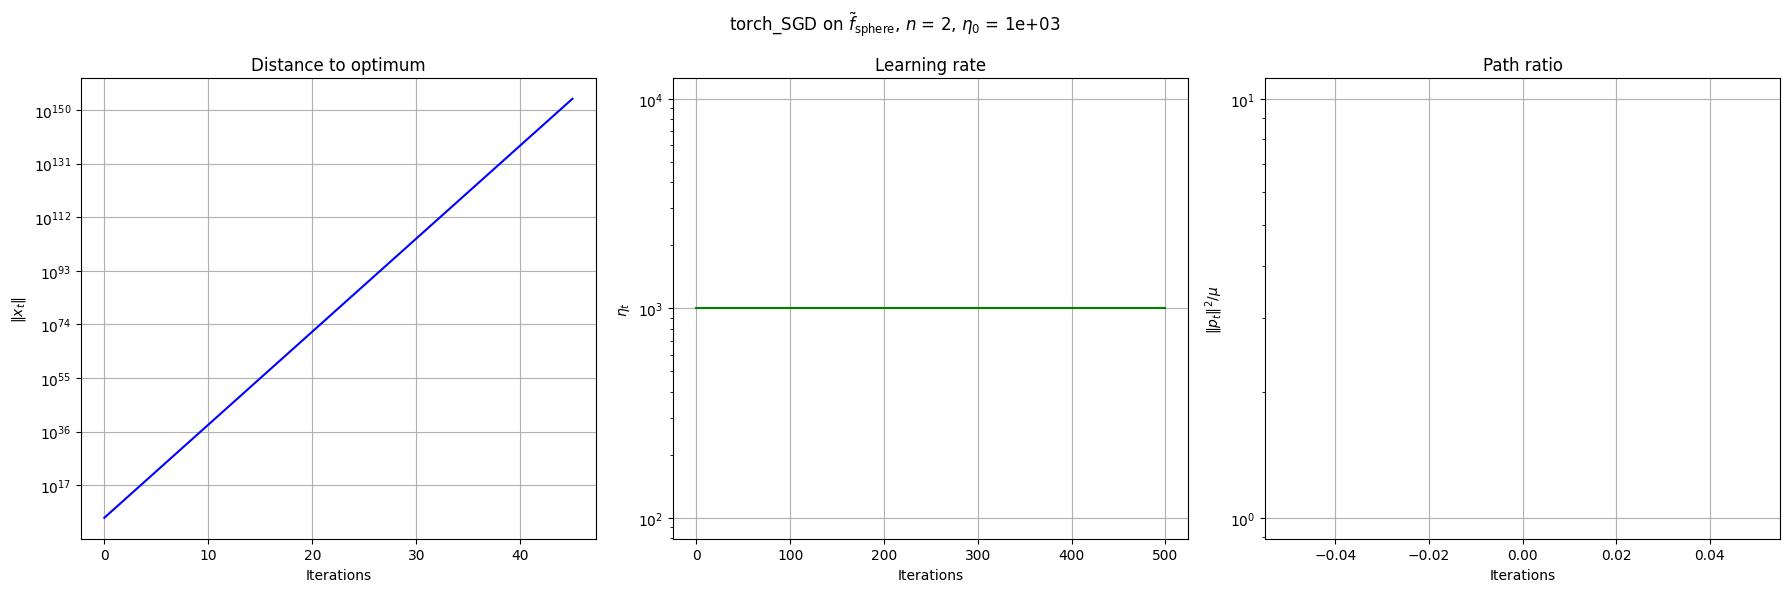

In [47]:
results = [[np.linalg.norm(x) for x in candidate_sol],
           learning_rates,
           path_ratios
           ]
fig_titles = ['Distance to optimum',
              'Learning rate',
              'Path ratio'
              ]
y_labels = [r'$\|x_t\|$',
            r'$\eta_t$',
            r'$\|p_t\|^2 / \mu$'
            ]
colors = ['b',
          'g',
          'r'
          ]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 2 rows, 2 columns
fig.suptitle(rf'{fig_title} on {f_name}, $n$ = {str(len(x0))}, $\eta_0$ = {lr0:.0e}')

for i, ax in enumerate(axes.flat):  # Iterate over subplots
    ax.semilogy(results[i], color=colors[i])
    ax.set_title(fig_titles[i])
    ax.set_xlabel('Iterations')
    ax.set_ylabel(y_labels[i])
    ax.grid(True)

# Adjust layout and show
plt.tight_layout()
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.svg')
plt.show()

In [2]:
def estimate_path_norm_squared_stats_vectorized(
    shape,
    num_trials=100,
    num_steps=100,
    betas=(0.9, 0.999),
    eps=1e-8,
    smoothing=0.2,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    beta1, beta2 = betas
    shape = tuple(shape)
    trials_shape = (num_trials,) + shape

    # Initialize states
    m = np.zeros(trials_shape)
    v = np.zeros(trials_shape)
    path = np.zeros(trials_shape)

    for t in range(1, num_steps + 1):
        # Vectorized sampling of Gaussian noise for all trials
        grad = np.random.randn(*trials_shape)

        # Adam update
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        adam_step = m_hat / (np.sqrt(v_hat) + eps)

        # Normalize each vector across the last dimensions
        norm = np.linalg.norm(adam_step, axis=tuple(range(1, len(trials_shape))), keepdims=True)
        normalized_step = adam_step / np.clip(norm, a_min=1e-12, a_max=None)

        # Exponential average
        path = (1 - smoothing) * path + smoothing * normalized_step

    # Compute squared norms for all trials
    path_squared_norms = np.sum(path**2, axis=tuple(range(1, len(trials_shape))))
    return path_squared_norms.mean(), path_squared_norms.std()


In [8]:
dims = [15, 42, 650]
for dim in dims:
    mean, std = estimate_path_norm_squared_stats_vectorized(shape=(dim,), num_trials=1000, num_steps=1000)
    print(f"Dim.: {dim}, Mean: {mean:.4f}, Std: {std:.4f}")

Dim.: 15, Mean: 0.6729, Std: 0.0814
Dim.: 42, Mean: 0.6770, Std: 0.0489
Dim.: 650, Mean: 0.6827, Std: 0.0119


In [6]:
def plot_path_norm_stats_vs_dimension(
    dims,
    num_trials=100,
    num_steps=100,
    betas=(0.9, 0.999),
    eps=1e-8,
    smoothing=0.2,
    seed=None
):
    means = []
    stds = []

    for d in dims:
        mean, std = estimate_path_norm_squared_stats_vectorized(
            shape=(d,),
            num_trials=num_trials,
            num_steps=num_steps,
            betas=betas,
            eps=eps,
            smoothing=smoothing,
            seed=seed
        )
        means.append(mean)
        stds.append(std)

    # Convert to NumPy arrays
    dims = np.array(dims)
    means = np.array(means)
    stds = np.array(stds)

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(dims, means, label='Mean of $\\|\\text{path}\\|^2$')
    plt.fill_between(dims, means - stds, means + stds, alpha=0.3, label='±1 Std Dev')
    plt.xlabel('Dimension')
    plt.ylabel(r'$\mathbb{E}[\|\mathrm{path}\|^2]$')
    plt.title(f'Path Norm Squared vs Dimension (steps={num_steps}, trials={num_trials})')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


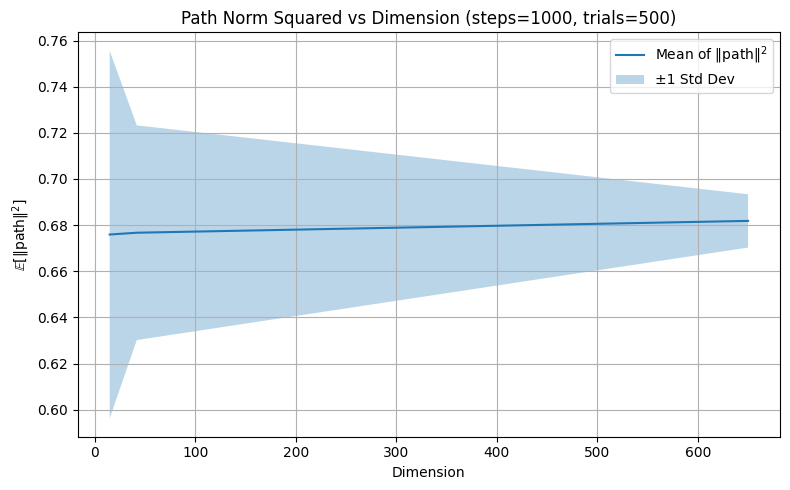

In [7]:
dims = [15, 42, 650]
plot_path_norm_stats_vs_dimension(dims, num_trials=500, num_steps=1000)